<a href="https://colab.research.google.com/github/dchu26/Causal-Representation-Learning-with-Partial-Observability/blob/main/Causal_Representation_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Install dependencies (usually first cell)
!pip install -q medmnist
!pip install -U medmnist seaborn
!pip install causal-learn

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from medmnist import INFO, OrganMNIST3D
import torch.nn.functional as F

# Dataset Prep

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class OrganMultiViewDataset(Dataset):
    def __init__(self, split: str, transform=None):
        from medmnist import OrganMNIST3D
        self.raw = OrganMNIST3D(split=split, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        volume, label = self.raw[idx]
        vol = np.squeeze(volume)         # (D, H, W)
        d, h, w = vol.shape
        axial    = vol[d//2, :, :]       # axial slice at center
        coronal  = vol[:, h//2, :]       # coronal slice
        sagittal = vol[:, :, w//2]       # sagittal slice
        # Apply transforms (e.g., ToTensor, Normalize)
        if self.transform:
            axial    = self.transform(axial)
            coronal  = self.transform(coronal)
            sagittal = self.transform(sagittal)
        else:
            axial    = torch.tensor(axial, dtype=torch.float32).unsqueeze(0)
            coronal  = torch.tensor(coronal, dtype=torch.float32).unsqueeze(0)
            sagittal = torch.tensor(sagittal, dtype=torch.float32).unsqueeze(0)
        return axial, coronal, sagittal, torch.tensor(label, dtype=torch.long).squeeze()

# Example transforms: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),                 # HxW -> 1xHxW, scales to [0,1]
    transforms.Normalize((0.5,), (0.5,))   # mean=0.5, std=0.5
])

# Instantiate datasets and dataloaders
train_ds = OrganMultiViewDataset(split='train', transform=transform)
val_ds   = OrganMultiViewDataset(split='val',   transform=transform)
test_ds  = OrganMultiViewDataset(split='test',  transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

In [3]:
print(len(val_ds))

161


# Architecture

In [4]:
class CNNEncoder(nn.Module):
    def __init__(self, out_features=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 28x28 -> 14x14
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 14x14 -> 7x7
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)   # 7x7 -> 1x1
        )
        self.fc = nn.Linear(128, out_features)

    def forward(self, x):
        x = self.conv(x)                # shape (batch, 128, 1, 1)
        x = x.view(x.size(0), -1)       # flatten to (batch, 128)
        x = self.fc(x)                  # (batch, latent_dim)
        return x

# Multi-view network combining the three encoders and a classifier
class MultiViewNet(nn.Module):
    def __init__(self, latent_dim=128, num_classes=11, return_latent=False):
        super().__init__()
        self.encoder_axial    = CNNEncoder(out_features=latent_dim)
        self.encoder_coronal  = CNNEncoder(out_features=latent_dim)
        self.encoder_sagittal = CNNEncoder(out_features=latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        self.return_latent = return_latent  # controls whether we return the fused latent vector

    def forward(self, axial, coronal, sagittal, mask, return_latent=False):
        f_ax = self.encoder_axial(axial)
        f_co = self.encoder_coronal(coronal)
        f_sa = self.encoder_sagittal(sagittal)

        f_ax = f_ax * mask[:, 0].unsqueeze(1)
        f_co = f_co * mask[:, 1].unsqueeze(1)
        f_sa = f_sa * mask[:, 2].unsqueeze(1)

        sum_mask = mask.sum(dim=1).unsqueeze(1)
        fused = (f_ax + f_co + f_sa) / (sum_mask + 1e-6)

        out = self.classifier(fused)

        if return_latent:
            return out, fused
        else:
            return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiViewNet(latent_dim=128, num_classes=11, return_latent=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
class CausalRegularizer(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.A = nn.Parameter(torch.randn(latent_dim, latent_dim) * 0.01)

    def acyclicity_loss(self):
        """Implements the NOTEARS acyclicity constraint"""
        d = self.A.shape[0]
        expm = torch.matrix_exp(self.A * self.A)  # elementwise square then matrix exp
        return torch.trace(expm) - d

    def forward(self, Z):
        # Optional: enforce sparsity or structure on A, e.g. L1 penalty
        return self.acyclicity_loss()


Masking Data

In [6]:
def create_masks(batch_size, mode):
    """
    Create a mask tensor (batch_size, 3) based on mode:
      - 'full': all ones,
      - 'dual': exactly two ones,
      - 'single': exactly one one,
      - 'random': 1 to 3 ones randomly.
    """
    mask = torch.zeros((batch_size, 3), dtype=torch.float32)
    for i in range(batch_size):
        if mode == 'full':
            mask[i] = torch.tensor([1, 1, 1], dtype=torch.float32)
        elif mode == 'dual':
            keep = random.sample([0, 1, 2], 2)
            mask[i, keep] = 1.0
        elif mode == 'single':
            keep = random.choice([0, 1, 2])
            mask[i, keep] = 1.0
        else:  # random
            k = random.choice([1, 2, 3])
            keep = random.sample([0, 1, 2], k)
            mask[i, keep] = 1.0
    return mask

causal_reg = CausalRegularizer(latent_dim=128).to(device)
lambda_causal = 0.1  # tune this weight

num_epochs = 80
for epoch in range(num_epochs):
    # Determine mask mode per epoch
    if epoch < 20:
        mode = 'full'
    elif epoch < 40:
        mode = 'dual'
    elif epoch < 60:
        mode = 'single'
    else:
        mode = 'random'

    model.train()
    total_loss = 0.0
    for axial, coronal, sagittal, labels in train_loader:
        axial = axial.to(device).float()
        coronal = coronal.to(device).float()
        sagittal = sagittal.to(device).float()
        labels = labels.to(device)
        mask = create_masks(labels.size(0), mode).to(device)

        # Forward pass with latent output
        outputs, latents = model(axial, coronal, sagittal, mask, return_latent=True)

        loss_cls = criterion(outputs, labels)
        loss_causal = causal_reg(latents)
        loss = loss_cls + lambda_causal * loss_causal

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / len(train_ds)

    # Validation (full views, no causal loss)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for axial, coronal, sagittal, labels in val_loader:
            axial = axial.to(device).float()
            coronal = coronal.to(device).float()
            sagittal = sagittal.to(device).float()
            labels = labels.to(device)
            mask = torch.ones((labels.size(0), 3), dtype=torch.float32).to(device)
            outputs = model(axial, coronal, sagittal, mask)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = 100.0 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Acc (full): {val_acc:.2f}%")


Epoch 1/80, Loss: 2.2855, Val Acc (full): 19.25%
Epoch 2/80, Loss: 1.9600, Val Acc (full): 32.92%
Epoch 3/80, Loss: 1.6973, Val Acc (full): 36.65%
Epoch 4/80, Loss: 1.4277, Val Acc (full): 52.17%
Epoch 5/80, Loss: 1.2656, Val Acc (full): 48.45%
Epoch 6/80, Loss: 1.1773, Val Acc (full): 57.14%
Epoch 7/80, Loss: 1.0646, Val Acc (full): 63.98%
Epoch 8/80, Loss: 0.9690, Val Acc (full): 64.60%
Epoch 9/80, Loss: 0.9135, Val Acc (full): 70.19%
Epoch 10/80, Loss: 0.8847, Val Acc (full): 67.70%
Epoch 11/80, Loss: 0.8092, Val Acc (full): 68.94%
Epoch 12/80, Loss: 0.7798, Val Acc (full): 65.84%
Epoch 13/80, Loss: 0.7153, Val Acc (full): 74.53%
Epoch 14/80, Loss: 0.6804, Val Acc (full): 72.05%
Epoch 15/80, Loss: 0.6170, Val Acc (full): 80.75%
Epoch 16/80, Loss: 0.6132, Val Acc (full): 78.88%
Epoch 17/80, Loss: 0.6744, Val Acc (full): 78.88%
Epoch 18/80, Loss: 0.6253, Val Acc (full): 82.61%
Epoch 19/80, Loss: 0.5427, Val Acc (full): 86.34%
Epoch 20/80, Loss: 0.5455, Val Acc (full): 80.12%
Epoch 21/

# Evaluation

Test Accuracy (full views): 87.38%


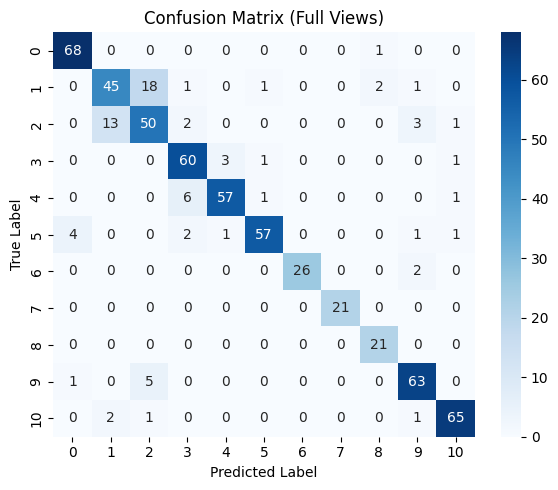

Test Accuracy (dual views): 83.44%


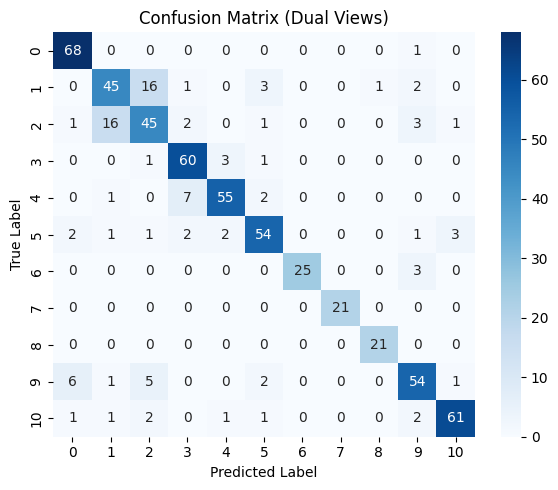

Test Accuracy (single views): 73.44%


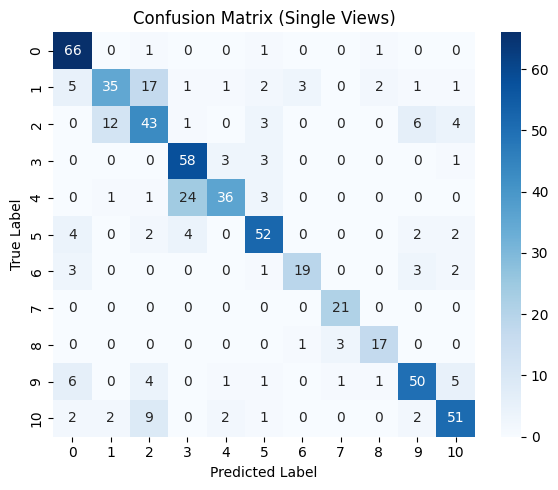

Test Accuracy (random views): 81.15%


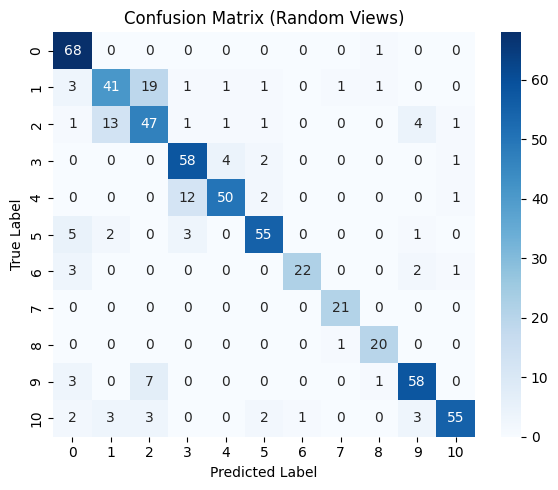

In [7]:
model.eval()
all_preds = []
all_labels = []
for eval_mode in ['full', 'dual', 'single', 'random']:
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for axial, coronal, sagittal, labels in test_loader:
            axial = axial.to(device).float()
            coronal = coronal.to(device).float()
            sagittal = sagittal.to(device).float()
            labels = labels.to(device)
            mask = create_masks(labels.size(0), eval_mode).to(device)
            outputs = model(axial, coronal, sagittal, mask)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy ({eval_mode} views): {acc:.2f}%")
    # Plot confusion matrix for the 'full' case
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({eval_mode.capitalize()} Views)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()



Test Accuracy (full views): 87.38%


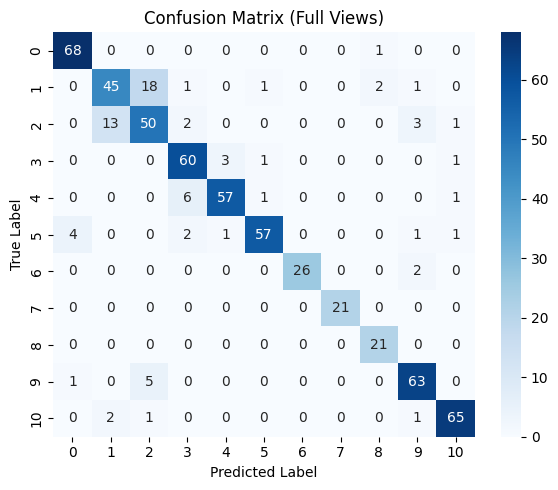

ROC-AUC (macro) (full views): 0.9919


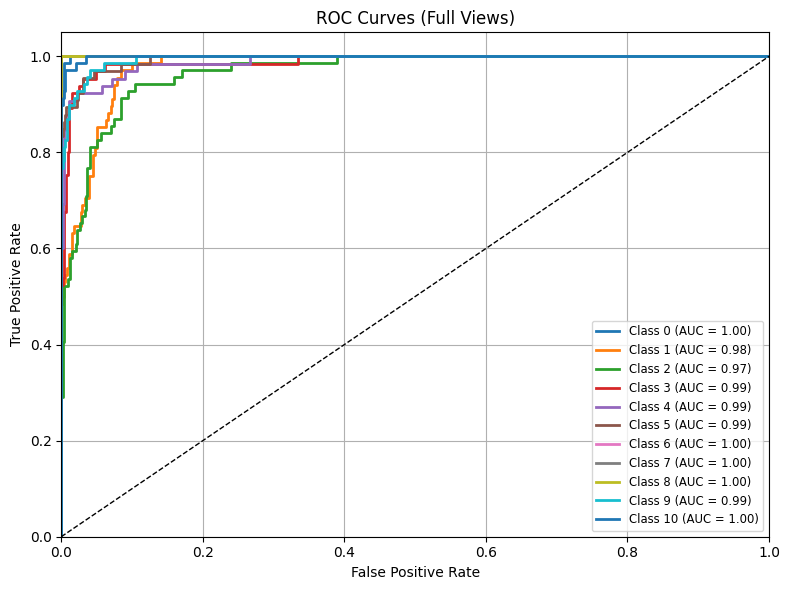


Test Accuracy (dual views): 84.59%


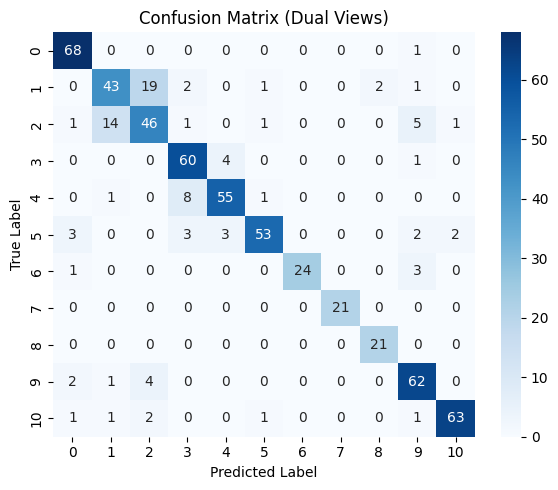

ROC-AUC (macro) (dual views): 0.9877


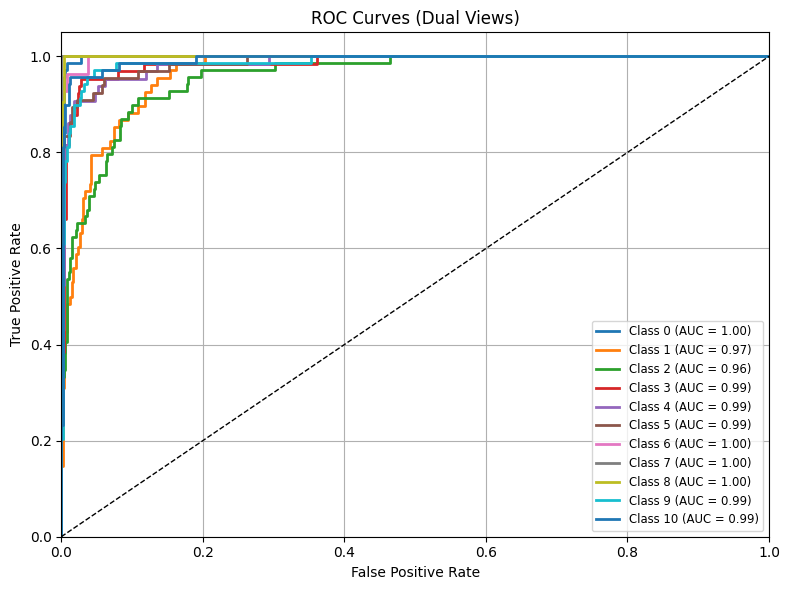


Test Accuracy (single views): 71.31%


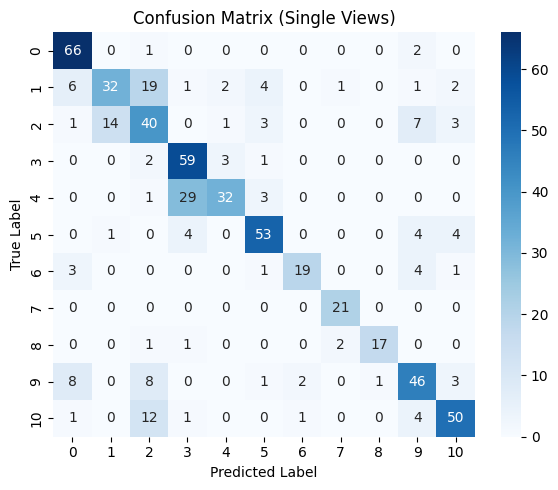

ROC-AUC (macro) (single views): 0.9660


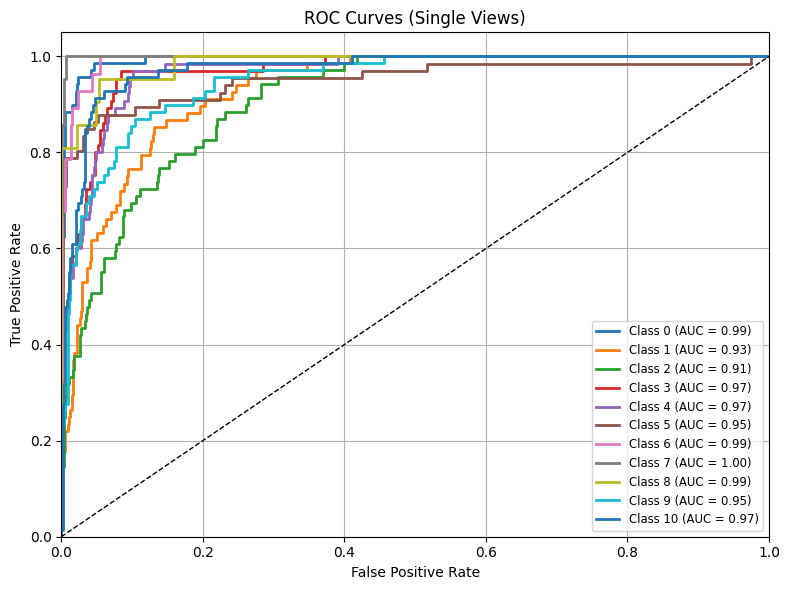


Test Accuracy (random views): 80.49%


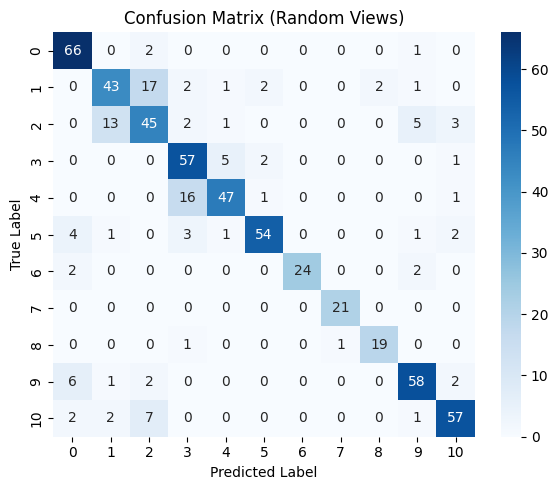

ROC-AUC (macro) (random views): 0.9853


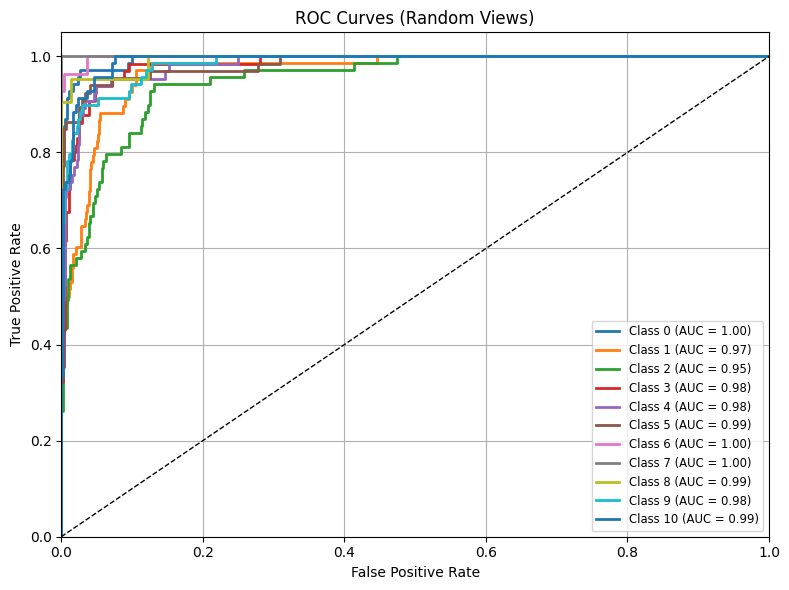

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F  # for softmax

model.eval()
num_classes = 11


for eval_mode in ['full', 'dual', 'single', 'random']:
    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for axial, coronal, sagittal, labels in test_loader:
            axial = axial.to(device).float()
            coronal = coronal.to(device).float()
            sagittal = sagittal.to(device).float()
            labels = labels.to(device)
            mask = create_masks(labels.size(0), eval_mode).to(device)

            outputs = model(axial, coronal, sagittal, mask)  # shape: [batch_size, num_classes]
            probs = F.softmax(outputs, dim=1)  # convert logits to probabilities
            preds = probs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(probs.cpu().numpy())  # store softmaxed outputs

    # Accuracy
    acc = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\nTest Accuracy ({eval_mode} views): {acc:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({eval_mode.capitalize()} Views)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # ROC-AUC
    y_true = label_binarize(all_labels, classes=list(range(num_classes)))  # one-hot
    y_score = np.array(all_logits)  # probabilities from softmax

    try:
        macro_roc_auc = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
        print(f"ROC-AUC (macro) ({eval_mode} views): {macro_roc_auc:.4f}")

        # ROC curves per class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curves
        plt.figure(figsize=(8, 6))
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves ({eval_mode.capitalize()} Views)')
        plt.legend(loc='lower right', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not compute ROC-AUC for {eval_mode}: {e}")



# Causal Discovery

In [9]:
model.eval()
all_latents = []
all_labels = []

with torch.no_grad():
    for axial, coronal, sagittal, labels in test_loader:
        axial = axial.to(device).float()
        coronal = coronal.to(device).float()
        sagittal = sagittal.to(device).float()
        mask = torch.ones((labels.size(0), 3), dtype=torch.float32).to(device)
        _, latents = model(axial, coronal, sagittal, mask, return_latent=True)

        all_latents.append(latents.cpu())
        all_labels.append(labels.cpu())

latents_all = torch.cat(all_latents).numpy()
labels_all = torch.cat(all_labels).numpy()

In [10]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz

# Run PC with Fisher's Z test, appropriate for continuous variables
pc_result = pc(
    data=latents_all,
    alpha=0.05,  # significance level for independence tests
    ci_test=fisherz
)

  0%|          | 0/128 [00:00<?, ?it/s]

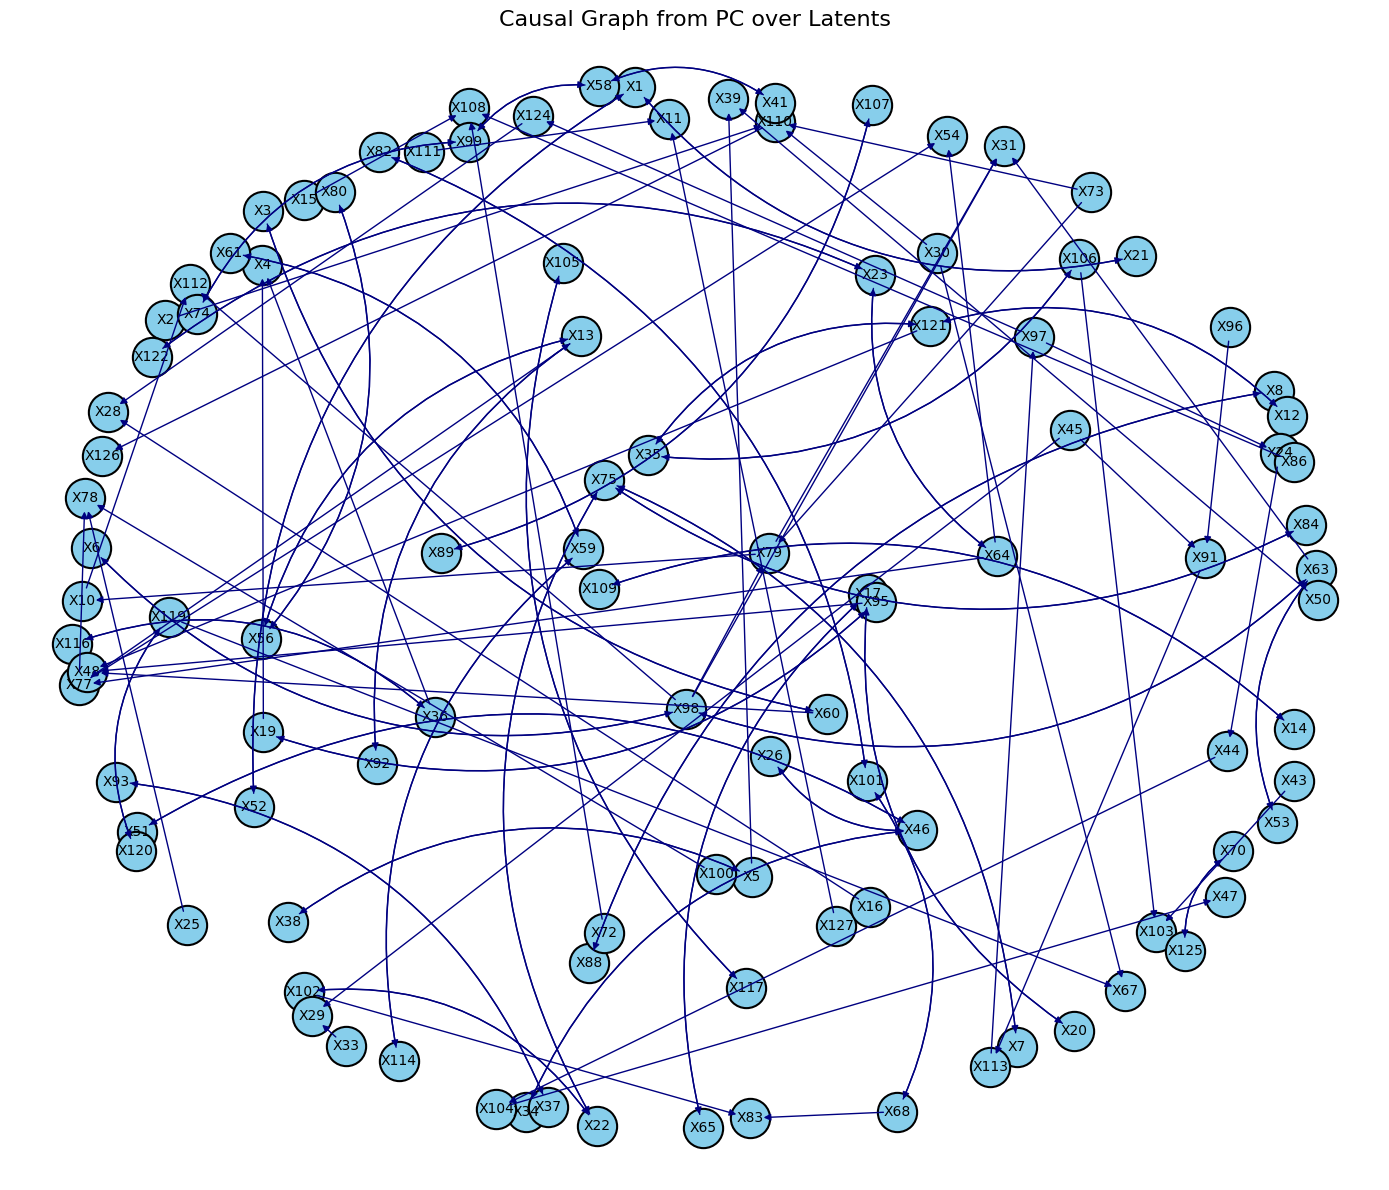

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_curved_edges(G, pos, rad=0.25, **kwargs):
    """Draw curved edges for bidirectional edges"""
    seen = set()
    ax = plt.gca()
    for (u, v) in G.edges():
        if (v, u) in G.edges() and (v, u) not in seen:
            # draw curved edge one way
            rad_pos = rad
            rad_neg = -rad
            # edge u->v curved one way
            ax.annotate("",
                        xy=pos[v], xycoords='data',
                        xytext=pos[u], textcoords='data',
                        arrowprops=dict(arrowstyle='-|>', color=kwargs.get('edge_color', 'k'),
                                        shrinkA=10, shrinkB=10,
                                        patchA=None, patchB=None,
                                        connectionstyle=f"arc3,rad={rad_pos}"),
                        )
            # edge v->u curved other way
            ax.annotate("",
                        xy=pos[u], xycoords='data',
                        xytext=pos[v], textcoords='data',
                        arrowprops=dict(arrowstyle='-|>', color=kwargs.get('edge_color', 'k'),
                                        shrinkA=10, shrinkB=10,
                                        patchA=None, patchB=None,
                                        connectionstyle=f"arc3,rad={rad_neg}"),
                        )
            seen.add((u, v))
            seen.add((v, u))
        elif (v, u) not in G.edges():
            # single edge straight line
            ax.annotate("",
                        xy=pos[v], xycoords='data',
                        xytext=pos[u], textcoords='data',
                        arrowprops=dict(arrowstyle='-|>', color=kwargs.get('edge_color', 'k'),
                                        shrinkA=10, shrinkB=10,
                                        patchA=None, patchB=None),
                        )

# Build graph (same as before)
G_nx = nx.DiGraph()
for edge in pc_result.G.get_graph_edges():
    i, j = edge.node1, edge.node2
    ep1, ep2 = edge.endpoint1, edge.endpoint2
    if ep1.name == 'TAIL' and ep2.name == 'ARROW':
        G_nx.add_edge(str(i), str(j))
    elif ep1.name == 'ARROW' and ep2.name == 'TAIL':
        G_nx.add_edge(str(j), str(i))
    elif ep1.name == 'ARROW' and ep2.name == 'ARROW':
        G_nx.add_edge(str(i), str(j))
        G_nx.add_edge(str(j), str(i))
    else:
        G_nx.add_edge(str(i), str(j))
        G_nx.add_edge(str(j), str(i))

pos = nx.spring_layout(G_nx, k=2.5, iterations=150, seed=42)

plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G_nx, pos,
                       node_size=800,
                       node_color='skyblue',
                       edgecolors='black',
                       linewidths=1.5)
nx.draw_networkx_labels(G_nx, pos, font_size=10, font_color='black')

# Draw edges with curvature for bidirectional edges
draw_curved_edges(G_nx, pos, rad=0.3, edge_color='navy')

plt.title("Causal Graph from PC over Latents", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("causal_graph_pc.png", dpi=300)
plt.show()

In [17]:
print("Number of nodes:", G_nx.number_of_nodes())
print("Number of edges:", G_nx.number_of_edges())

Number of nodes: 105
Number of edges: 130


In [12]:
# For each node, get its parents from the graph
parents_dict = {}
for node in G_nx.nodes():
    parents = list(G_nx.predecessors(node))
    parents_dict[node] = parents

In [13]:
def create_causal_features(latents, parents_dict):
    n_samples, n_latents = latents.shape
    causal_feats = []

    for node_str in sorted(parents_dict.keys(), key=lambda x: int(x[1:])):
        node_idx = int(node_str[1:])
        parent_indices = [int(p[1:]) for p in parents_dict[node_str]]

        # Start with the node itself
        combined = latents[:, node_idx:node_idx+1]

        # Concatenate parent latents
        if parent_indices:
            parents_latents = latents[:, parent_indices]
            combined = torch.cat([combined, parents_latents], dim=1)

        # Example aggregation: sum over combined features (customize as needed)
        feat = combined.sum(dim=1, keepdim=True)  # shape (batch_size, 1)
        causal_feats.append(feat)

    return torch.cat(causal_feats, dim=1)  # shape (batch_size, n_latents)


In [14]:
class CausalClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [15]:
# Run one batch to get the shape of causal features
model.eval()
with torch.no_grad():
    for axial, coronal, sagittal, labels in train_loader:
        axial = axial.to(device).float()
        coronal = coronal.to(device).float()
        sagittal = sagittal.to(device).float()
        mask = create_masks(labels.size(0), mode).to(device)

        outputs, latents = model(axial, coronal, sagittal, mask, return_latent=True)
        causal_features = create_causal_features(latents, parents_dict)

        if isinstance(causal_features, np.ndarray):
            causal_features = torch.tensor(causal_features, dtype=torch.float32, device=device)
        else:
            causal_features = causal_features.float().to(device)

        input_dim = causal_features.shape[1]  # Number of latent features per sample
        break  # only need first batch

Epoch 1/20 - Train Loss: 1.3298 - Train Acc: 0.5664
Epoch 2/20 - Train Loss: 0.5817 - Train Acc: 0.8157
Epoch 3/20 - Train Loss: 0.5013 - Train Acc: 0.8280
Epoch 4/20 - Train Loss: 0.4306 - Train Acc: 0.8363
Epoch 5/20 - Train Loss: 0.4141 - Train Acc: 0.8579
Epoch 6/20 - Train Loss: 0.3906 - Train Acc: 0.8713
Epoch 7/20 - Train Loss: 0.3260 - Train Acc: 0.8816
Epoch 8/20 - Train Loss: 0.3717 - Train Acc: 0.8548
Epoch 9/20 - Train Loss: 0.3090 - Train Acc: 0.8877
Epoch 10/20 - Train Loss: 0.3011 - Train Acc: 0.8908
Epoch 11/20 - Train Loss: 0.3053 - Train Acc: 0.8816
Epoch 12/20 - Train Loss: 0.2827 - Train Acc: 0.8939
Epoch 13/20 - Train Loss: 0.3280 - Train Acc: 0.8857
Epoch 14/20 - Train Loss: 0.2936 - Train Acc: 0.8908
Epoch 15/20 - Train Loss: 0.2910 - Train Acc: 0.8805
Epoch 16/20 - Train Loss: 0.3676 - Train Acc: 0.8692
Epoch 17/20 - Train Loss: 0.2768 - Train Acc: 0.8857
Epoch 18/20 - Train Loss: 0.2754 - Train Acc: 0.9022
Epoch 19/20 - Train Loss: 0.3000 - Train Acc: 0.8857
Ep

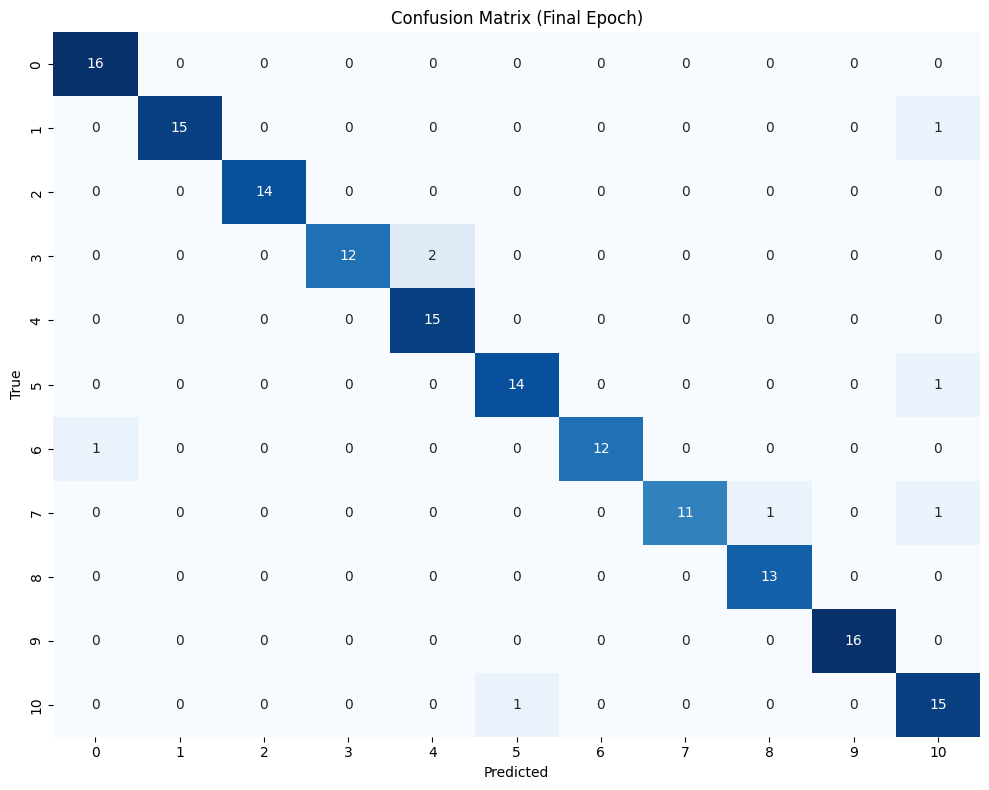

Final Accuracy:  0.9503
Precision (macro): 0.9563
Recall (macro):    0.9486
F1 Score (macro):  0.9503


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

num_classes = 11
classifier = CausalClassifier(input_dim, num_classes).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=1e-3)

# Track metrics
all_preds_final = []
all_labels_final = []

num_epochs = 20
lambda_causal = 1e-2  # You can adjust this

for epoch in range(num_epochs):
    model.train()
    classifier.train()
    total_loss = 0
    epoch_preds = []
    epoch_labels = []

    for axial, coronal, sagittal, labels in train_loader:
        axial = axial.to(device).float()
        coronal = coronal.to(device).float()
        sagittal = sagittal.to(device).float()
        labels = labels.to(device)
        mask = create_masks(labels.size(0), mode).to(device)

        outputs, latents = model(axial, coronal, sagittal, mask, return_latent=True)
        causal_features = create_causal_features(latents, parents_dict)

        if isinstance(causal_features, np.ndarray):
            causal_features = torch.tensor(causal_features, dtype=torch.float32, device=device)
        else:
            causal_features = causal_features.float().to(device)

        preds_causal = classifier(causal_features)
        loss_cls = criterion(preds_causal, labels)
        loss_causal = causal_reg(latents)
        loss = loss_cls + lambda_causal * loss_causal

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)

        epoch_preds.extend(preds_causal.argmax(dim=1).detach().cpu().numpy())
        epoch_labels.extend(labels.detach().cpu().numpy())

    epoch_acc = accuracy_score(epoch_labels, epoch_preds)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss / len(train_loader.dataset):.4f} - Train Acc: {epoch_acc:.4f}")

# --- Final Evaluation & Confusion Matrix ---
model.eval()
classifier.eval()
with torch.no_grad():
    for axial, coronal, sagittal, labels in val_loader:
        axial = axial.to(device).float()
        coronal = coronal.to(device).float()
        sagittal = sagittal.to(device).float()
        labels = labels.to(device)
        mask = create_masks(labels.size(0), mode).to(device)

        outputs, latents = model(axial, coronal, sagittal, mask, return_latent=True)
        causal_features = create_causal_features(latents, parents_dict)

        if isinstance(causal_features, np.ndarray):
            causal_features = torch.tensor(causal_features, dtype=torch.float32, device=device)
        else:
            causal_features = causal_features.float().to(device)

        preds = classifier(causal_features)
        preds_labels = preds.argmax(dim=1)

        all_preds_final.extend(preds_labels.cpu().numpy())
        all_labels_final.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels_final, all_preds_final)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Final Epoch)")
plt.tight_layout()
plt.savefig("confusion_matrix_final.png", dpi=300)
plt.show()

# Metrics
acc = accuracy_score(all_labels_final, all_preds_final)
prec = precision_score(all_labels_final, all_preds_final, average='macro', zero_division=0)
rec = recall_score(all_labels_final, all_preds_final, average='macro', zero_division=0)
f1 = f1_score(all_labels_final, all_preds_final, average='macro', zero_division=0)

print(f"Final Accuracy:  {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro):    {rec:.4f}")
print(f"F1 Score (macro):  {f1:.4f}")


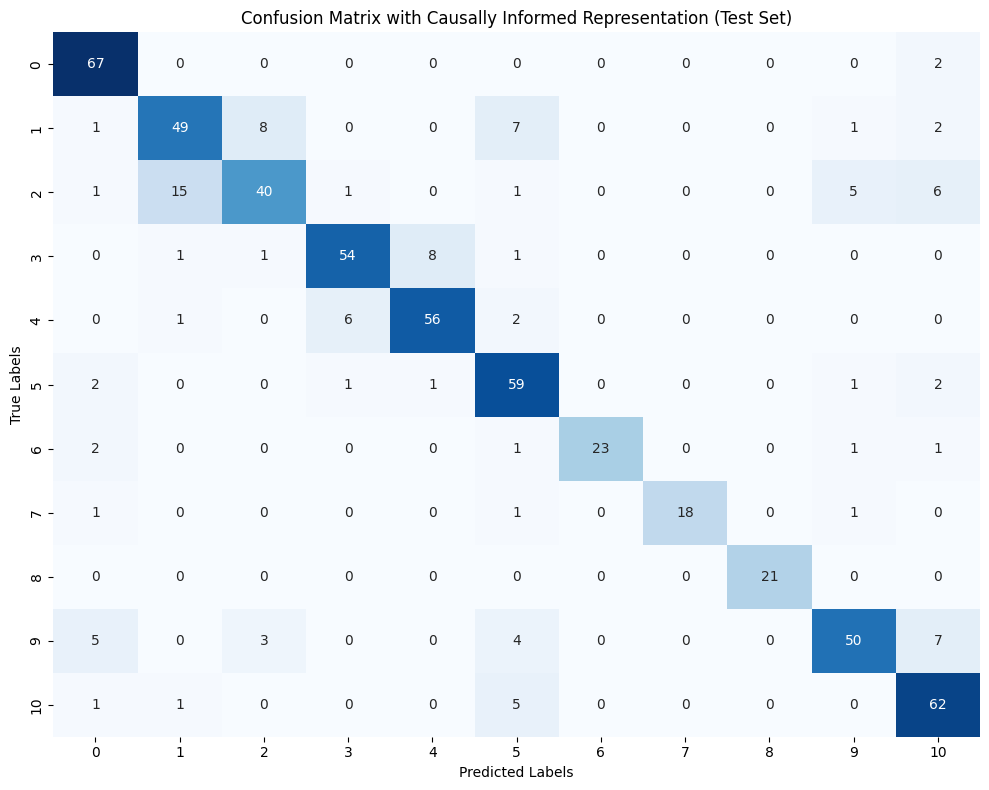

Test Accuracy:  0.8180
Test Precision (macro): 0.8548
Test Recall (macro):    0.8327
Test F1 Score (macro):  0.8390


In [21]:
# --- Test Set Evaluation ---
all_preds_test = []
all_labels_test = []

model.eval()
classifier.eval()
with torch.no_grad():
    for axial, coronal, sagittal, labels in test_loader:
        axial = axial.to(device).float()
        coronal = coronal.to(device).float()
        sagittal = sagittal.to(device).float()
        labels = labels.to(device)
        mask = create_masks(labels.size(0), mode).to(device)

        outputs, latents = model(axial, coronal, sagittal, mask, return_latent=True)
        causal_features = create_causal_features(latents, parents_dict)

        if isinstance(causal_features, np.ndarray):
            causal_features = torch.tensor(causal_features, dtype=torch.float32, device=device)
        else:
            causal_features = causal_features.float().to(device)

        preds = classifier(causal_features)
        preds_labels = preds.argmax(dim=1)

        all_preds_test.extend(preds_labels.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Test Confusion Matrix
cm_test = confusion_matrix(all_labels_test, all_preds_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with Causally Informed Representation (Test Set)")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=300)
plt.show()

# Test Metrics
acc_test = accuracy_score(all_labels_test, all_preds_test)
prec_test = precision_score(all_labels_test, all_preds_test, average='macro', zero_division=0)
rec_test = recall_score(all_labels_test, all_preds_test, average='macro', zero_division=0)
f1_test = f1_score(all_labels_test, all_preds_test, average='macro', zero_division=0)

print(f"Test Accuracy:  {acc_test:.4f}")
print(f"Test Precision (macro): {prec_test:.4f}")
print(f"Test Recall (macro):    {rec_test:.4f}")
print(f"Test F1 Score (macro):  {f1_test:.4f}")
